In [1]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
import os, torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Built with CUDA:", torch.version.cuda)     
print("CUDA available?:", torch.cuda.is_available())  
print("Device count:", torch.cuda.device_count())

CUDA_VISIBLE_DEVICES: 0
Built with CUDA: 12.4
CUDA available?: True
Device count: 1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from semisupervised import SemiSupervisedAutoEncoderOptions, SemiSupervisedAdversarialAutoencoder

In [5]:
from torch.utils.data import random_split

def configure_mnist(batch_size=100, val_size=10000):
    # transform: ToTensor + flatten
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    # full train + test datasets
    full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # split full_train → train_ds (60k - val_size) and val_ds (val_size)
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size])

    # DataLoaders
    train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # (Optionally) extract raw tensors:
    X_train = torch.stack([x for x, _ in train_ds])
    Y_train = torch.tensor([y for _, y in train_ds])
    X_val   = torch.stack([x for x, _ in val_ds])
    Y_val   = torch.tensor([y for _, y in val_ds])
    X_test  = torch.stack([x for x, _ in test_ds])
    Y_test  = test_ds.targets.clone()

    return (X_train, X_val, X_test,
            Y_train, Y_val, Y_test,
            train_loader, val_loader, test_loader)

In [6]:
(X_train, X_val, X_test, Y_train, Y_val, Y_test, train_loader, val_loader, test_loader) = configure_mnist()

print(Y_train.max())
print(Y_train.min())

tensor(9)
tensor(0)


In [4]:
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 15
PRIOR_STD = 5.0

recon_loss = nn.MSELoss()
init_recon_lr = 0.01

semi_sup_loss = nn.CrossEntropyLoss()
init_semi_sup_lr = 0.01

init_gen_lr = init_disc_lr = 0.1
use_decoder_sigmoid = True

In [5]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = SemiSupervisedAdversarialAutoencoder(options);

In [9]:
model.train_mbgd(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=30,
    prior_std=PRIOR_STD,
)

Epoch [1/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/30 — Recon: 0.2298, Disc_Cat: 1.3768, Gen_Cat: 0.6970, Disc_Style: 0.3769, Gen_Style: 3.0420, SemiSup: 1.0777
Validation Accuracy: 86.52%



Epoch [2/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/30 — Recon: 0.2242, Disc_Cat: 1.3347, Gen_Cat: 0.7227, Disc_Style: 0.7367, Gen_Style: 2.5821, SemiSup: 0.3747
Validation Accuracy: 90.73%



Epoch [3/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/30 — Recon: 0.1970, Disc_Cat: 1.3041, Gen_Cat: 0.8029, Disc_Style: 0.9881, Gen_Style: 1.8815, SemiSup: 0.3250
Validation Accuracy: 92.91%



Epoch [4/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/30 — Recon: 0.1014, Disc_Cat: 1.3313, Gen_Cat: 0.8332, Disc_Style: 1.1437, Gen_Style: 1.3936, SemiSup: 0.2895
Validation Accuracy: 94.05%



Epoch [5/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/30 — Recon: 0.0735, Disc_Cat: 1.3413, Gen_Cat: 0.8191, Disc_Style: 1.2164, Gen_Style: 1.1799, SemiSup: 0.2493
Validation Accuracy: 94.50%



Epoch [6/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/30 — Recon: 0.0708, Disc_Cat: 1.3494, Gen_Cat: 0.8051, Disc_Style: 1.2485, Gen_Style: 1.0767, SemiSup: 0.2100
Validation Accuracy: 95.36%



Epoch [7/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/30 — Recon: 0.0698, Disc_Cat: 1.3530, Gen_Cat: 0.7955, Disc_Style: 1.2766, Gen_Style: 1.0066, SemiSup: 0.1857
Validation Accuracy: 96.10%



Epoch [8/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/30 — Recon: 0.0694, Disc_Cat: 1.3570, Gen_Cat: 0.7867, Disc_Style: 1.2879, Gen_Style: 0.9806, SemiSup: 0.1616
Validation Accuracy: 96.12%



Epoch [9/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/30 — Recon: 0.0691, Disc_Cat: 1.3588, Gen_Cat: 0.7807, Disc_Style: 1.3064, Gen_Style: 0.9241, SemiSup: 0.1522
Validation Accuracy: 96.78%



Epoch [10/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/30 — Recon: 0.0687, Disc_Cat: 1.3618, Gen_Cat: 0.7741, Disc_Style: 1.3091, Gen_Style: 0.9076, SemiSup: 0.1379
Validation Accuracy: 96.93%



Epoch [11/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11/30 — Recon: 0.0686, Disc_Cat: 1.3658, Gen_Cat: 0.7663, Disc_Style: 1.3243, Gen_Style: 0.8697, SemiSup: 0.1191
Validation Accuracy: 97.20%



Epoch [12/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12/30 — Recon: 0.0685, Disc_Cat: 1.3671, Gen_Cat: 0.7586, Disc_Style: 1.3332, Gen_Style: 0.8522, SemiSup: 0.1088
Validation Accuracy: 97.17%



Epoch [13/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13/30 — Recon: 0.0683, Disc_Cat: 1.3678, Gen_Cat: 0.7560, Disc_Style: 1.3410, Gen_Style: 0.8303, SemiSup: 0.1037
Validation Accuracy: 97.22%



Epoch [14/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14/30 — Recon: 0.0681, Disc_Cat: 1.3710, Gen_Cat: 0.7476, Disc_Style: 1.3385, Gen_Style: 0.8245, SemiSup: 0.0849
Validation Accuracy: 97.57%



Epoch [15/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15/30 — Recon: 0.0680, Disc_Cat: 1.3711, Gen_Cat: 0.7452, Disc_Style: 1.3474, Gen_Style: 0.8175, SemiSup: 0.0784
Validation Accuracy: 97.41%



Epoch [16/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16/30 — Recon: 0.0679, Disc_Cat: 1.3722, Gen_Cat: 0.7410, Disc_Style: 1.3526, Gen_Style: 0.7901, SemiSup: 0.0801
Validation Accuracy: 97.57%



Epoch [17/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17/30 — Recon: 0.0677, Disc_Cat: 1.3735, Gen_Cat: 0.7374, Disc_Style: 1.3538, Gen_Style: 0.7901, SemiSup: 0.0651
Validation Accuracy: 97.80%



Epoch [18/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18/30 — Recon: 0.0676, Disc_Cat: 1.3754, Gen_Cat: 0.7320, Disc_Style: 1.3592, Gen_Style: 0.7827, SemiSup: 0.0577
Validation Accuracy: 97.85%



Epoch [19/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19/30 — Recon: 0.0675, Disc_Cat: 1.3758, Gen_Cat: 0.7293, Disc_Style: 1.3615, Gen_Style: 0.7718, SemiSup: 0.0528
Validation Accuracy: 97.93%



Epoch [20/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20/30 — Recon: 0.0672, Disc_Cat: 1.3772, Gen_Cat: 0.7264, Disc_Style: 1.3662, Gen_Style: 0.7596, SemiSup: 0.0473
Validation Accuracy: 97.90%



Epoch [21/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 21/30 — Recon: 0.0669, Disc_Cat: 1.3777, Gen_Cat: 0.7244, Disc_Style: 1.3634, Gen_Style: 0.7640, SemiSup: 0.0434
Validation Accuracy: 97.97%



Epoch [22/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 22/30 — Recon: 0.0671, Disc_Cat: 1.3781, Gen_Cat: 0.7219, Disc_Style: 1.3617, Gen_Style: 0.7659, SemiSup: 0.0377
Validation Accuracy: 98.13%



Epoch [23/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 23/30 — Recon: 0.0667, Disc_Cat: 1.3791, Gen_Cat: 0.7189, Disc_Style: 1.3655, Gen_Style: 0.7632, SemiSup: 0.0335
Validation Accuracy: 98.12%



Epoch [24/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 24/30 — Recon: 0.0667, Disc_Cat: 1.3795, Gen_Cat: 0.7174, Disc_Style: 1.3702, Gen_Style: 0.7502, SemiSup: 0.0325
Validation Accuracy: 97.87%



Epoch [25/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 25/30 — Recon: 0.0661, Disc_Cat: 1.3798, Gen_Cat: 0.7158, Disc_Style: 1.3694, Gen_Style: 0.7460, SemiSup: 0.0268
Validation Accuracy: 98.09%



Epoch [26/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 26/30 — Recon: 0.0659, Disc_Cat: 1.3804, Gen_Cat: 0.7148, Disc_Style: 1.3728, Gen_Style: 0.7398, SemiSup: 0.0250
Validation Accuracy: 98.23%



Epoch [27/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 27/30 — Recon: 0.0664, Disc_Cat: 1.3808, Gen_Cat: 0.7129, Disc_Style: 1.3725, Gen_Style: 0.7371, SemiSup: 0.0203
Validation Accuracy: 98.02%



Epoch [28/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 28/30 — Recon: 0.0658, Disc_Cat: 1.3810, Gen_Cat: 0.7117, Disc_Style: 1.3736, Gen_Style: 0.7393, SemiSup: 0.0170
Validation Accuracy: 98.07%



Epoch [29/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 29/30 — Recon: 0.0658, Disc_Cat: 1.3823, Gen_Cat: 0.7096, Disc_Style: 1.3763, Gen_Style: 0.7304, SemiSup: 0.0153
Validation Accuracy: 98.17%



Epoch [30/30]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 30/30 — Recon: 0.0655, Disc_Cat: 1.3829, Gen_Cat: 0.7081, Disc_Style: 1.3757, Gen_Style: 0.7328, SemiSup: 0.0134
Validation Accuracy: 98.33%



In [10]:
all_probs, all_preds = [], []
for imgs, _ in test_loader:
    probs, preds = model.predict(imgs)
    all_probs.append(probs.cpu())
    all_preds.append(preds.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)

In [11]:
num_correct = torch.eq(all_preds, Y_test).sum().item()
accuracy = num_correct / Y_test.size(0)
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 98.14%


In [12]:
model.save_weights("run_1_weights/aae_weights")

Weights saved to run_1_weights/aae_weights_*.pth


## Image Generation

In [8]:
model.load_weights("run_1_weights/aae_weights")

Weights loaded from run_1_weights/aae_weights_*.pth


In [118]:
img7 = model.generate_images(2, prior_std=37.0)  

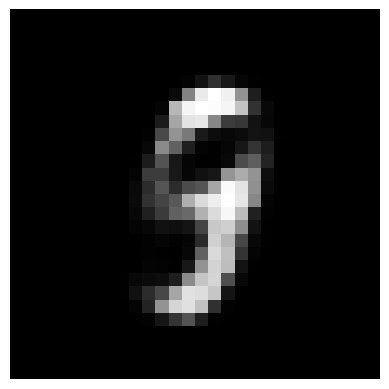

In [119]:
import matplotlib.pyplot as plt

plt.imshow(img7.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()